# Opdracht schilderijen

In [1]:
from tensorflow import keras 
from keras import layers
from keras.utils import image_dataset_from_directory
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train_data = image_dataset_from_directory("dataset/train", image_size=(180, 180))
val_data = image_dataset_from_directory("dataset/validation", image_size=(180, 180))
test_data = image_dataset_from_directory("dataset/test", image_size=(180, 180))

dataset\train\Picasso\150.jpg --> FAILED
dataset\test\Picasso\1503.jpg --> FAILED


## Model opbouwen

In [6]:
input_layer = keras.Input(shape=(180, 180, 3)) 
x = layers.Rescaling(1. / 255)(input_layer)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4, activation="softmax")(x)  # 4 because we have 4 classes (0 through 3)

model = keras.Model(inputs=input_layer, outputs=outputs)

# Return the compiled model
model.compile(loss="sparse_categorical_crossentropy",
  # categorical crossentropy because we're dealing with multiclass, single label classification
  optimizer=keras.optimizers.RMSprop(),
  metrics=["accuracy"],  # =0.00001
  )

Epoch 1/30
115/115 [==============================] - 28s 242ms/step - loss: 1.5313 - accuracy: 0.4113 - val_loss: 1.0910 - val_accuracy: 0.6074
Epoch 2/30
115/115 [==============================] - 30s 260ms/step - loss: 0.8548 - accuracy: 0.6186 - val_loss: 0.7162 - val_accuracy: 0.7500
Epoch 3/30
115/115 [==============================] - 17s 150ms/step - loss: 0.6692 - accuracy: 0.7208 - val_loss: 0.5589 - val_accuracy: 0.8443
Epoch 4/30
115/115 [==============================] - 18s 158ms/step - loss: 0.5073 - accuracy: 0.7837 - val_loss: 0.7069 - val_accuracy: 0.7090
Epoch 5/30
115/115 [==============================] - 18s 154ms/step - loss: 0.4046 - accuracy: 0.8349 - val_loss: 0.4153 - val_accuracy: 0.8574
Epoch 6/30
115/115 [==============================] - 18s 153ms/step - loss: 0.3515 - accuracy: 0.8475 - val_loss: 0.3094 - val_accuracy: 0.9066
Epoch 7/30
115/115 [==============================] - 17s 151ms/step - loss: 0.2949 - accuracy: 0.8741 - val_loss: 0.3741 - val_ac

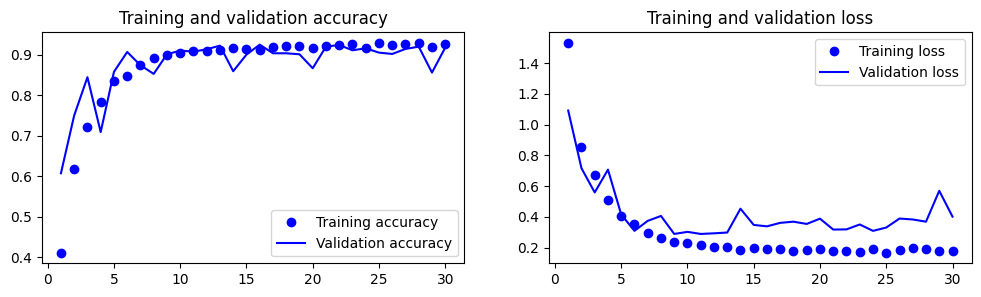

In [7]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch.keras",  # file waarin model wordt opgeslagen
    save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
    monitor="val_loss")
]

history = model.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    callbacks=callbacks
)

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_size_inches(12, 3)

ax1.plot(epochs, accuracy, "bo", label="Training accuracy")
ax1.plot(epochs, val_accuracy, "b", label="Validation accuracy")
ax1.set_title("Training and validation accuracy")
ax1.legend()
# plt.figure()

ax2.plot(epochs, loss, "bo", label="Training loss")
ax2.plot(epochs, val_loss, "b", label="Validation loss")
ax2.set_title("Training and validation loss")
ax2.legend()
plt.show()

In [ ]:
model.summary()